# Differentiating Regular and Pneumonia X-rays with ML
### By Haoyuan Pang and Bradley Russavage

In [1]:
# Import required libraries
import os
import cv2 # opencv
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio # tensorflow-io


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import cross_val_score

## Define Functions

In [2]:
main_path = os.getcwd() + '/data/covid_xray/'
train_path = main_path + 'train/'
test_path = main_path + 'test/'

max_dim = 200 # pixels
normal = []
pneumonia = []

def precision_recall(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp 
    fn = np.sum(conf_matrix, axis=1) - tp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall


def get_metrics(y_test, predicted, title):
    conf_matrix = confusion_matrix(y_test, predicted)
    cm_plot = plt.imshow(conf_matrix)
    plt.colorbar(cm_plot)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0,1], ["Normal (0)", "Pneumonia (1)"])
    plt.yticks([0,1], ["Normal (0)", "Pneumonia (1)"])
    plt.title(title)
    plt.show()
    print(pd.DataFrame(conf_matrix, columns=["Normal (0)", "Pneumonia (1)"], index=["Normal (0)", "Pneumonia (1)"]))
    print("")
    print(precision_recall(conf_matrix))
    
    
# Requires images to be downloaded
def convert_images(subpath):
    global normal, pneumonia
    for i in ['NORMAL/', 'PNEUMONIA/']:
        path = subpath + i
        for xray in os.listdir(path):
            # print(xray) # image name

            # Convert image to np array using opencv
            try:
                img = cv2.imread(path + xray)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
                img_resize = cv2.resize(img, (max_dim, max_dim), cv2.INTER_AREA) # shrink img to 200 by 200
                
                
                if i == "NORMAL/":
                    normal.append(img_resize)
                    #normal = np.append(normal, img_resize, axis=0)
                else:
                    pneumonia.append(img_resize)
                    #pneumonia = np.append(pneumonia, img_resize, axis=0)
                    
            except Exception as e:
                print(e)

        print("Finished " + i)

## Data preprocessing

In [4]:
# Only use these functions if you have the data manually downloaded

#convert_images(train_path)
#convert_images(test_path)

# Write to a file for ease of data access
# normal = np.asarray(normal)
# pneumonia = np.asarray(pneumonia)
# np.save(main_path + "normal_arr.npy", normal)
# np.save(main_path + "pneu_arr.npy", pneumonia)

# Load data from data.npy
#normal = np.load(main_path + "normal_arr.npy", allow_pickle=True)
#pneumonia = np.load(main_path + "pneu_arr.npy", allow_pickle=True)

#print(normal.shape)
#print(pneumonia.shape)

In [5]:
# Load data from silk server
URL_NORM = "https://brussava.w3.uvm.edu/cs254/covid_xray/normal_arr.npy"
resp = requests.get(URL_NORM)
resp.raise_for_status()
normal = np.load(io.BytesIO(resp.content), allow_pickle=True)

URL_PNEU = "https://brussava.w3.uvm.edu/cs254/covid_xray/pneu_arr.npy"
resp = requests.get(URL_PNEU)
resp.raise_for_status()
pneumonia = np.load(io.BytesIO(resp.content), allow_pickle=True)


print(f"Normal size: {normal.shape}")
print(f"Pneumonia size: {pneumonia.shape}")

Normal size: (1575, 200, 200)
Pneumonia size: (4265, 200, 200)


In [6]:
# Visualize an xray image
print(normal[1])

# This shows as a popup window
#cv2.imshow('Test', normal[1])
#cv2.waitKey(0) # Do not delete this line or the notebook kernel will crash

[[14 23 27 ... 29 23 19]
 [19 21 27 ... 31 25 18]
 [14 24 29 ... 27 23 17]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [8]:
URL_MULTI = "https://brussava.w3.uvm.edu/cs254/multi_xray/training_all.npy"
resp = requests.get(URL_MULTI)
resp.raise_for_status()
multi = np.load(io.BytesIO(resp.content), allow_pickle=True)


# You can also get the files individually for each classification at:
# https://brussava.w3.uvm.edu/cs254/multi_xray/training_num.npy
# where num = 0 to 14

In [4]:
multi.shape

(15000, 200, 200)

Multi in order of classification (with element amount)
- 0 Aortic enlargement
    - 1127
- 1 Atelectasis
    - 30
- 2 Calcification
    - 91
- 3 Cardiomegaly
    - 878
- 4 Consolidation
    - 46
- 5 ILD
    - 111
- 6 Infiltration
    - 134
- 7 Lung Opacity
    - 251
- 8 Nodule/Mass
    - 221
- 9 Other lesion
    - 224
- 10 Pleural effusion
    - 241
- 11 Pleural thickening
    - 496
- 12 Pneumothorax
    - 22
- 13 Pulmonary fibrosis
    - 522
- 14 No findings
    - 10606

In [6]:
# TESTING SECTION


# import shutil
# csv_path = "D:\\Downloads\\archive\\train.csv"
# dicom_p = "D:\\Downloads\\archive\\train\\"

# dicom_df = pd.read_csv(csv_path)
# dicom_df = dicom_df.loc[:,['image_id','class_id']]

# dicom_df.shape[0]

# # Make folders for classifiers
# for n in range(15):
#     os.mkdir(dicom_p + str(n))

# # Place them into their respective folders 
# for i in range(dicom_df.shape[0]):
#     name, clf = dicom_df.iloc[i]
#     try:
#         shutil.move(dicom_p + name + ".png", dicom_p + str(clf) + "\\" + name + ".png")
#     except:
#         pass
# d_all = []

# for n in range(15):
#     path = dicom_p + str(n) + "\\"
#     dicoms = []
#     print(f"Started {n}")
#     for img_url in os.listdir(path):
        
        
# #         img_bytes = tf.io.read_file(path + img_url)
# #         image = tfio.image.decode_dicom_image(img_bytes, dtype=tf.uint16)
# #         image = image.numpy()[0]
#         image = cv2.imread(path + img_url)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.resize(image, (max_dim, max_dim), cv2.INTER_AREA)
#         dicoms.append(image)
#         d_all.append(image)

#     dicoms = np.asarray(dicoms)
#     print(f"{n} shape: {dicoms.shape}")
#     np.save(f"D:\\Downloads\\archive\\training_{str(n)}.npy", dicoms)
#     print(f"Finished {n}")
        
# d_all = np.asarray(d_all)
# np.save("D:\\Downloads\\archive\\training_all.npy", d_all)
        
# test = np.load("E:\\CS254 FP Data\\training_0.npy", allow_pickle=True)
# print(test.shape)

# URL_MULTI = "https://brussava.w3.uvm.edu/cs254/multi_xray/training.npy"
# resp = requests.get(URL_MULTI)
# resp.raise_for_status()
# dicoms = np.load(io.BytesIO(resp.content), allow_pickle=True)

# print(dicoms.shape)
        
# when differentiating in training, y should be in order 0-14
        

# cv2.imshow('', image)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [28]:
# d_all = np.asarray(d_all)
# np.save("D:\\Downloads\\archive\\training_all.npy", d_all)

In [5]:
# d_all.shape

In [ ]:
# Convert from 3D to 2D
print("Before flattening")
print(normal.shape)
print(pneumonia.shape)

examples_n, dim_x_n, dim_y_n = normal.shape
normal = normal.reshape((examples_n, dim_x_n * dim_y_n))

examples_p, dim_x_p, dim_y_p = pneumonia.shape
pneumonia = pneumonia.reshape((examples_p, dim_x_p * dim_y_p))

print("\nAfter flattening")
print(normal.shape)
print(pneumonia.shape)

# Create X and Y
X = np.append(normal, pneumonia, axis=0)
y = np.array([0 for _ in range(normal.shape[0])])
y = np.append(y, [1 for _ in range(pneumonia.shape[0])], axis=0)


# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print("Training x:", x_train.shape, "y:", y_train.shape)
print("Testing x:", x_test.shape, "y:", y_test.shape)

print("Before normalization:")
print(x_train[10])

# Normalize RGB values from 0-255 to 0-1 (div by 255)
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

print("\nAfter normalization:")
print(x_train[10])

## Random Forest

In [8]:
# 70 chosen after iterating though different estimators
rf_class = RandomForestClassifier(n_estimators=70, random_state=0)
rf_pred = rf_class.fit(x_train, y_train).predict(x_test)

Accuracy: 0.9452054794520548


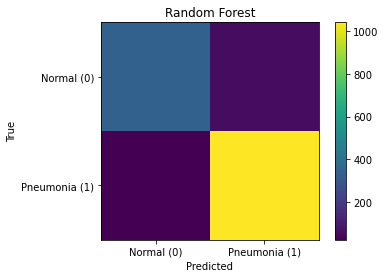

               Normal (0)  Pneumonia (1)
Normal (0)            339             57
Pneumonia (1)          23           1041

(array([0.93646409, 0.94808743]), array([0.85606061, 0.97838346]))
None
              precision    recall  f1-score   support

           0       0.94      0.86      0.89       396
           1       0.95      0.98      0.96      1064

    accuracy                           0.95      1460
   macro avg       0.94      0.92      0.93      1460
weighted avg       0.94      0.95      0.94      1460



In [9]:
print(f"Accuracy: {rf_class.score(x_test, y_test)}")
print(get_metrics(y_test, rf_pred, "Random Forest"))
print(classification_report(y_test, rf_pred))

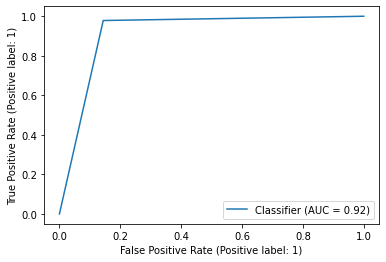

In [10]:
RocCurveDisplay.from_predictions(y_test, rf_pred)
plt.show()

In [14]:
rf_scores = cross_val_score(rf_class, X, y) # Default is 5-fold CV

In [16]:
print(f"RF 5 cv acc: {rf_scores.mean()} std dev: {rf_scores.std()}")

RF 5 cv acc: 0.9294520547945204 std dev: 0.0413469783842178


## SVM

In [11]:
svc = SVC(kernel="poly")
svc_predicted = svc.fit(x_train, y_train).predict(x_test)

### SVM Metrics

Accuracy: 0.9404109589041096


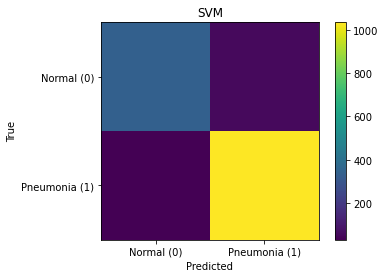

               Normal (0)  Pneumonia (1)
Normal (0)            339             57
Pneumonia (1)          30           1034

(array([0.91869919, 0.94775435]), array([0.85606061, 0.97180451]))
None
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       396
           1       0.95      0.97      0.96      1064

    accuracy                           0.94      1460
   macro avg       0.93      0.91      0.92      1460
weighted avg       0.94      0.94      0.94      1460



In [12]:
print(f"Accuracy: {svc.score(x_test, y_test)}")
print(get_metrics(y_test, svc_predicted, "SVM"))
print(classification_report(y_test, svc_predicted))

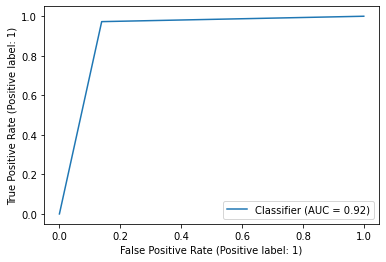

In [60]:
RocCurveDisplay.from_predictions(y_test, svc_predicted)
plt.show()

In [101]:
# This was just used as a sanity check 
# img = cv2.imread(main_path + "val\\PNEUMONIA\\person1946_bacteria_4875.jpeg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_resize = cv2.resize(img, (max_dim, max_dim), cv2.INTER_AREA)

# print(img_resize.shape)

# dim_i_x, dim_i_y = img_resize.shape
# img_resize = img_resize.reshape((dim_i_x * dim_i_y))
# img_resize = [img_resize]

# svc.predict(img_resize)

(200, 200)


array([1])

In [17]:
svc_scores = cross_val_score(svc, X, y) # Default is 5-fold CV

In [18]:
print(f"SVC 5 cv acc: {svc_scores.mean()} std dev: {svc_scores.std()}")

SVC 5 cv acc: 0.9342465753424657 std dev: 0.04201107115339727
